# Python for data analysis project

Contributors: Alexis JAMBUT - Gabriel FERNANDEZ CASA

## 1. Import

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from IPython.display import display
import seaborn as sns
!pip install catboost
%matplotlib inline
import numpy
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


##2. Read CSV

In [120]:
# chargement du dataset
onlineNewsPopularity_df = pd.read_csv("OnlineNewsPopularity/OnlineNewsPopularity.csv")
onlineNewsPopularity_df.info()
# On peut voir que notre dataset possède 39644 news repertoriées ainsi que 61 colonnes (dont 58 features et une target)
# Les colonnes sont toutes de type float sauf la colonne url (string) et les shares (int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords                   

In [121]:
# Nous nous sommes rendu compte qu'il y avait des espaces devant les noms de colonne (par exemple "dataset[' shares']")
# Afin que cela soit plus pratique à l'utilisation, nous avons décidé de retirer tous les espaces au début des colonnes
for col in onlineNewsPopularity_df.columns: 
    if col[0]==" ":
        onlineNewsPopularity_df.rename(columns={col:col[1:]}, inplace = True)
onlineNewsPopularity_df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [122]:
# Récupération des features du dataset (58 cols énumérés dans le OnlineNewsPopularity/OnlineNewsPopularity.names et de la target)
# Ainsi nous supprimons l'url de la news et egalement le timedelta qui correspond au nombre de jour entre
# la creation du dataset et la publication de l'article
# En fait, la description du dataset explique que ces deux variables sont des features "non-predictive"
onlineNewsPopularity_df.drop(labels=['url', 'timedelta'], axis = 1, inplace=True)
onlineNewsPopularity_df.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


## 3. Data-visualisation (utilisez matplotlib, searborn, bokeh…) – montrez le lien entre les variables et la cible

### Missing values

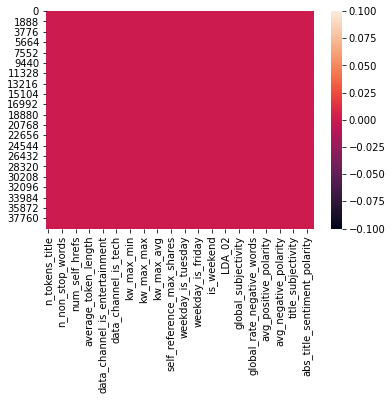

In [69]:
sns.heatmap(onlineNewsPopularity_df.isna())

Il ne semble pas avoir de valeur manquante dans le dataset, comme indiqué dans la description de ce dernier.

### Répartitions de la cible

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


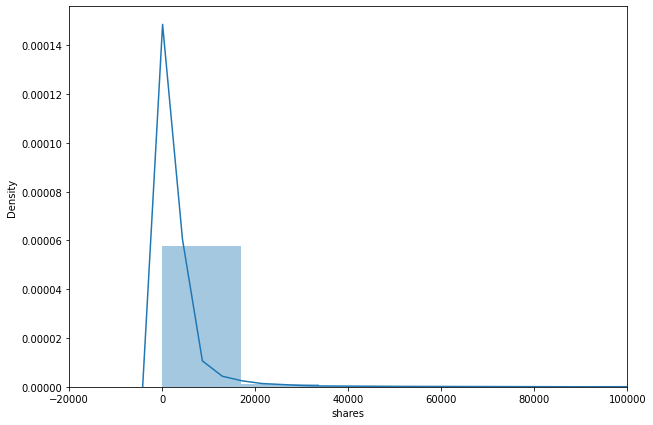

In [70]:
y=onlineNewsPopularity_df['shares']
plt.figure(figsize=(10,7))
plt.xlim([-20000, 100000])
sns.distplot(y, kde=True);

On peut voir ici que le nombre de share des article se situe majoritairement entre 0 et 20000 partage.

In [71]:
onlineNewsPopularity_df['shares'].describe()

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64

On peut même voir que le maximum de partage se situe à 843300 pour un article.

### Analyse des données sur différentes variables du dataset (Title Length, Categories, week days...)

##### Title length

In [72]:
# Relation entre la longueur du titre et le nombre de share
df_no_outliers = onlineNewsPopularity_df[onlineNewsPopularity_df["shares"]<=8362]

title_length_df = df_no_outliers.loc[:,["n_tokens_title", "shares"]]  # creating a new dataframe with length of title and number of shares

title_length_df_sorted = title_length_df.sort_values('n_tokens_title') # sorting the dataframe based on the lenght of the titles

distinct_title_keywords_count=(title_length_df_sorted.n_tokens_title.unique()) 

#distinct_title_keywords_count

numOfArticles = {} 

for token in distinct_title_keywords_count: 

    tempDf = title_length_df_sorted[title_length_df_sorted["n_tokens_title"]==token] 

    numOfArticles[token] = len(tempDf.n_tokens_title) 

numOfArticles



{2.0: 1,
 3.0: 5,
 4.0: 27,
 5.0: 170,
 6.0: 756,
 7.0: 1968,
 8.0: 3923,
 9.0: 5813,
 10.0: 6876,
 11.0: 6487,
 12.0: 4943,
 13.0: 3260,
 14.0: 1596,
 15.0: 707,
 16.0: 237,
 17.0: 81,
 18.0: 21,
 19.0: 5,
 20.0: 2,
 23.0: 1}

In [73]:
#2, 3, 4, 17, 18, 19, 20 and 23 ont moins de 100 articles chacuns

#On va donc les supprimer car on peut considérer que cela n'est pas pertinent de les garder

del_indices = [0,1,2,15,16,17,18,19] 

distinct_title_keywords_count = np.delete(distinct_title_keywords_count, del_indices)

In [74]:
# Nous cherchons maintenant la moyenne des shares pour chaque longueur de titre d'article

avg_shares_per_title_length = {}

for row in distinct_title_keywords_count:

    df_tokenwise = title_length_df_sorted[title_length_df_sorted["n_tokens_title"]== row]

    Avg = df_tokenwise["shares"].mean()

    avg_shares_per_title_length[row] = Avg

avg_shares_per_title_length

{5.0: 2216.323529411765,
 6.0: 2028.2843915343915,
 7.0: 2053.901422764228,
 8.0: 1973.700739230181,
 9.0: 1955.0775847238947,
 10.0: 1898.8490401396161,
 11.0: 1919.7316170803144,
 12.0: 1846.2443860004046,
 13.0: 1835.1895705521472,
 14.0: 1864.3659147869673,
 15.0: 1801.2503536067893,
 16.0: 1911.8776371308018}

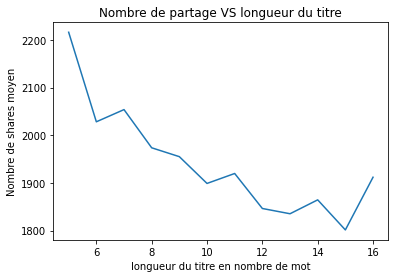

In [75]:
Avg_list =[] 

for token in avg_shares_per_title_length: 

    Avg_list = Avg_list + [avg_shares_per_title_length[token]] 


plt.plot(distinct_title_keywords_count, Avg_list) 

plt.xlabel('longueur du titre en nombre de mot') 

plt.ylabel('Nombre de shares moyen') 

plt.title('Nombre de partage VS longueur du titre') 

plt.show()

Au vu de ce plot, la longueur du titre semble être une feature interressante même si cela reste a comfirmé

##### Article Category (social media, tech, business ...)

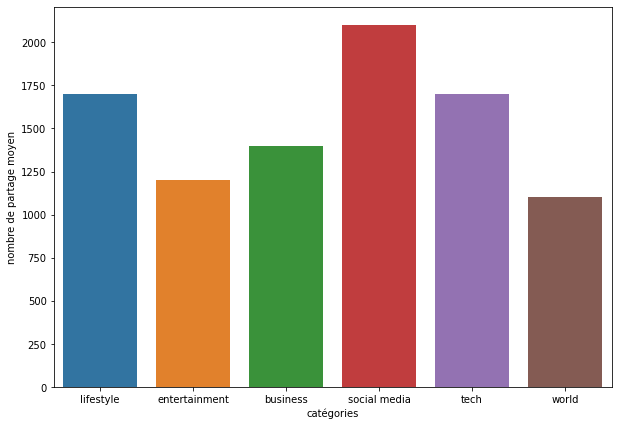

In [76]:
# On va maintenant s'intéresser aux catégories des articles en fonctions de leur nombre de partage moyens

channel = []
for d in ['data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world']:
    channel.append(onlineNewsPopularity_df[onlineNewsPopularity_df[d]==1]['shares'].median())

plt.figure(figsize=(10, 7))
ax = sns.barplot(x= ['lifestyle',
       'entertainment', 'business',
       'social media', 'tech',
       'world'], y= channel)
ax.set(xlabel='catégories', ylabel='nombre de partage moyen')
plt.show()

On peut voir que les catégories réseaux sociaux, tech et lifestyle sont très partagées. Alors que la catégorie world est la moins partagée.

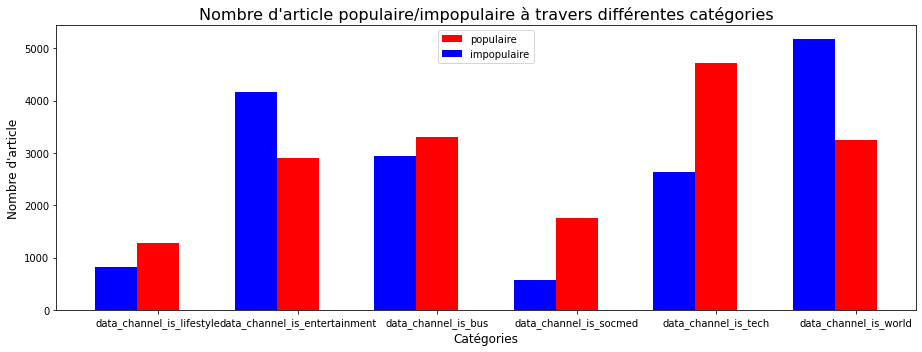

In [77]:
# On peut définir 2 catégories d'articles (populaire/impopulaire)
# On définie un seuil de 1400 pour le nombre de share, ce qui nous permet de définir un article "populaire" ou non
# Cette valeur n'a pas été défini par hasard et est donné par la description du dataset ici OnlineNewsPopularity/OnlineNewsPopularity.names
# Elle correspond en faite à la valeur qui sépare le dataset en deux groupe bien distinct
# Shares Value Range:   Number of Instances in Range:
#   <  1400            18490
#   >= 1400            21154
unpop=onlineNewsPopularity_df[onlineNewsPopularity_df['shares']<1400]
pop=onlineNewsPopularity_df[onlineNewsPopularity_df['shares']>=1400]

columns_chan=onlineNewsPopularity_df.columns.values[11:17]
unpop_chan = unpop[columns_chan].sum().values
pop_chan = pop[columns_chan].sum().values
fig = plt.figure(figsize = (13,5))
plt.title("Nombre d'article populaire/impopulaire à travers différentes catégories", fontsize = 16)
plt.bar(np.arange(len(columns_chan)), pop_chan, width = 0.3, align="center", color = 'r', \
          label = "populaire")
plt.bar(np.arange(len(columns_chan)) - 0.3, unpop_chan, width = 0.3, align = "center", color = 'b', \
          label = "impopulaire")
plt.xticks(np.arange(len(columns_chan)), columns_chan)

plt.ylabel("Nombre d'article", fontsize = 12)
plt.xlabel("Catégories", fontsize = 12)
    
plt.legend(loc = 'upper center')
plt.tight_layout()
plt.show()

On peut voir que les articles tech et reseaux sociaux sont très majoritairement populaire, alors que c'est le contraire pour la catégorie world et entertainment.

##### Week day

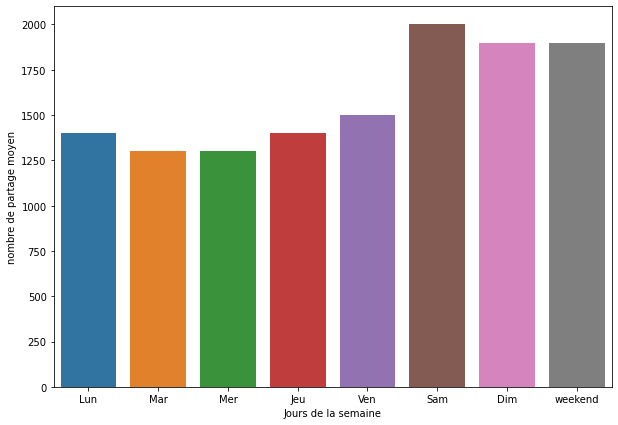

In [78]:
# On va maintenant regarder quel est l'impacte des jours de la semaine sur la popularité (nombre moyen de partage) d'un article
shares = []
for d in ['weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday','weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday',
       'weekday_is_sunday', 'is_weekend']:
    shares.append(onlineNewsPopularity_df[onlineNewsPopularity_df[d]==1]['shares'].median())
plt.figure(figsize=(10, 7))

ax = sns.barplot(x= ['Lun','Mar','Mer','Jeu','Ven','Sam','Dim', "weekend"], y= shares)
ax.set(xlabel='Jours de la semaine', ylabel='nombre de partage moyen')
plt.show()

On peut voir grâce à ce plot que les articles parus le weekend sont, de manière générale, plus populaire que ceux parues
la semaine.

On peut dire également que les variables weekend et sam/dim sont quasiment identiques, on pourrait donc supprimer les colonnes
samedi et dimanche afin d'avoir moins de features car elles sont extrêmement corrélées.
On pourrait également supprimé les features de la semaine. En effet, ces-dernières sont quasiment identiques. On pourrait donc seulement se réferrer à la feature is_weekend.

#### Words in content

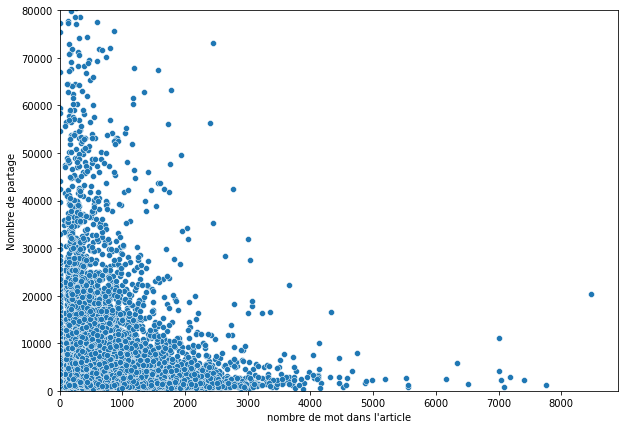

In [79]:
plt.figure(figsize=(10, 7))
sp = sns.scatterplot(data=onlineNewsPopularity_df, x="n_tokens_content", y="shares")
sp.set(xlabel='nombre de mot dans l\'article', ylabel='Nombre de partage')
# control x and y limits
plt.ylim(0, 80000)
plt.xlim(0, None)
plt.show()

On peut voir ici que lorsque le nombre de mot dans un article est assez grand, il a beaucoup de chance d'être impopulaire. Neanmoins l'inverse n'est pas exacte. En effet, avoir peu de mot dans l'article ne signifie pas qu'un article va être populaire. 

#### number of Keyword

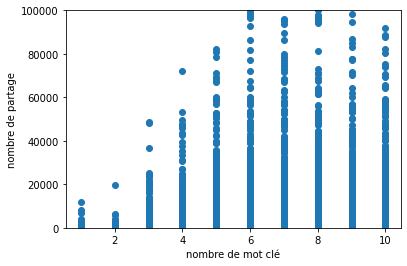

In [125]:
plt.scatter(onlineNewsPopularity_df['num_keywords'], onlineNewsPopularity_df['shares'])

plt.xlabel('nombre de mot clé')
plt.ylabel('nombre de partage')
plt.ylim([0, 100000])

plt.show()

On peut voir que les articles avec peu de mot clé sont peu partagés

##4. Correlation analysis

Attaquons nous maintenant plus profondement à la corrélation entre les données.
Certaines features ont l'air extrêmement corrélées et peuvent être supprimées car elles sont redondantes.

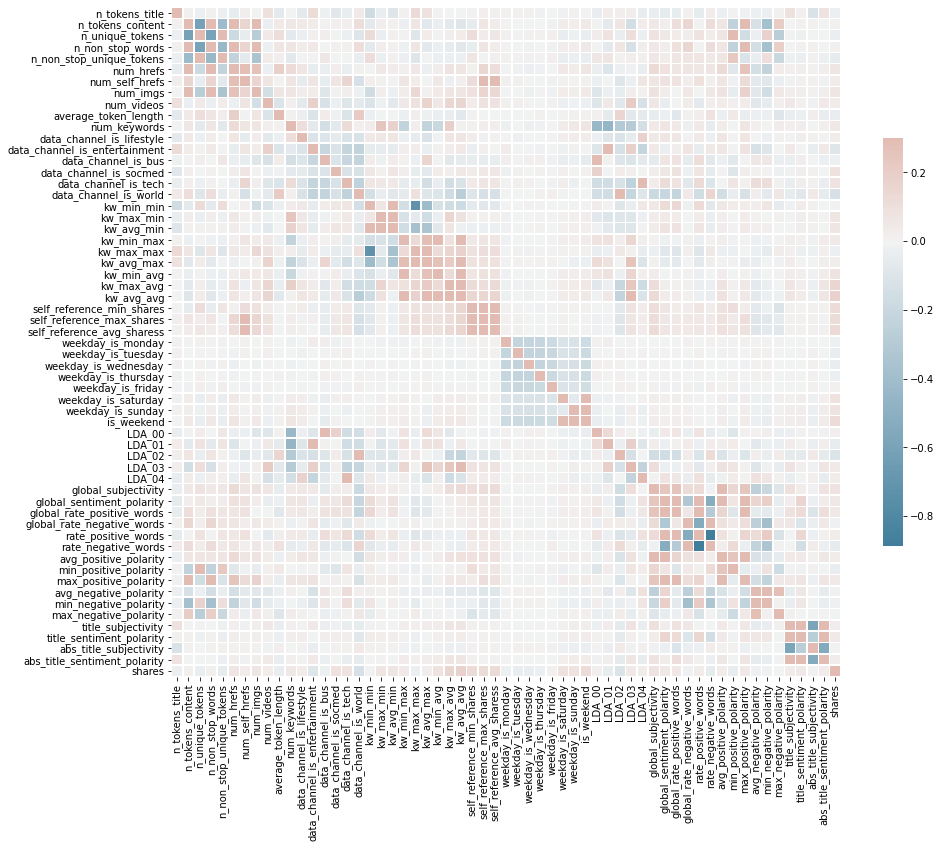

In [81]:
onlineNewsPopularity_correlation = onlineNewsPopularity_df.corr(method='kendall')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(onlineNewsPopularity_correlation,cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

En analysant cette **matrice de corrélation**, on peut constater que certaines variables sont fortement corrélées (positivement ou négativement).

On a:
- les variables "*weekday_is_**" qui sont fortement corrélées à la feature **is_weekend**,
- les variables "*self_reference_min_share*" ou "*self_reference_max_share*" corrélées à la feature **self_reference_avg_share** 
- les variables "*kw_max_min*" et "*kw_min_min*" qui sont corrélées à la feature **kw_avg_min**
- les variables "*min_positive_polarity*" et "*max_positive_polarity*" qui sont corrélées à la feature "*avg_positive_polarity*"
- les variables "*min_negative_polarity*" et "*max_negative_polarity*" qui sont corrélées à la feature **avg_negative_polarity**

Grâce à cette analyse de la **matrice de corrélation**, nous sommes en mesure de supprimer les features qui semblent redondantes (voir la liste "*features_to_remove*" dans la cellule suivante)



In [82]:
# Liste dans laquelle nous allons placer toutes les features à supprimer.
features_to_remove = ['weekday_is_saturday','weekday_is_sunday','weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 
                      'weekday_is_thursday', 'weekday_is_friday', 'kw_min_min', 'kw_max_min','kw_min_max', 'kw_max_max', 'kw_min_avg',
                      'kw_max_avg', 'self_reference_min_shares',
                      'self_reference_max_shares','n_non_stop_words','min_positive_polarity', 'max_positive_polarity','min_negative_polarity',
                      'max_negative_polarity'
                      ]

##5. Feature Subset Selection

L'objectif principal de ce projet est de **prédire la popularité d'un article** en fonction des différentes features du dataset. La popularité d'un article est désignée par son **nombre de partages** ("*shares*").​ La description du dataset fournit un **seuil du nombre de partages (1400 partages)** indiquant si un article est populaire ou non (populaire >= 1400 partages).

Il s'agit donc d'un problème dit **supervisé** puisque nous devons prédire une colonne en particulier ("*shares*").

Il existe deux approches pour les problèmes supervisés:
- la **régression** (Affecter une valeur numérique à une observation)
- la **classification** (Affecter une étiquette à une observation)

Pour ce problème, nous avons décidé de réaliser une **classification** en se basant sur le seuil du nombre de partage fournit par la description du dataset.

**Important**: Nous aurions pu passer par la régression, en tentant de trouver le nombre de partage pour un article donné mais nous estimions que le seuil fournit par le dataset est assez signigicatif.



In [83]:
# Ici on récupère la variable "shares" et on génère un dataframe indiquant la popularité pour chaque article du dataset
# Article populaire = True
# Article non populaire = False
shares_labels = pd.Series(onlineNewsPopularity_df["shares"]>=1400) 
shares_labels

0        False
1        False
2         True
3        False
4        False
         ...  
39639     True
39640     True
39641     True
39642    False
39643    False
Name: shares, Length: 39644, dtype: bool

In [84]:
# Sachant qu'on a stocké les labels à prédire pour la classification, nous pouvons supprimer la colonne "shares"
onlineNewsPopularity_df.drop(labels=['shares'], axis = 1, inplace=True)
onlineNewsPopularity_df.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364


In [85]:
# Ici on supprime les features que nous avons jugées redondantes et fortement corrélées
onlineNewsPopularity_features = onlineNewsPopularity_df.copy()
onlineNewsPopularity_features.drop(labels=features_to_remove, axis = 1, inplace=True)

In [86]:
onlineNewsPopularity_features.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_avg_min,kw_avg_max,kw_avg_avg,self_reference_avg_sharess,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,12.0,219.0,0.663594,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.000000,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,-0.350000,0.500000,-0.187500,0.000000,0.187500
1,9.0,255.0,0.604743,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,-0.118750,0.000000,0.000000,0.500000,0.000000
2,9.0,211.0,0.575130,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,918.000000,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,-0.466667,0.000000,0.000000,0.500000,0.000000
3,9.0,531.0,0.503788,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,-0.369697,0.000000,0.000000,0.500000,0.000000
4,13.0,1072.0,0.415646,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3151.157895,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,-0.220192,0.454545,0.136364,0.045455,0.136364


In [87]:
onlineNewsPopularity_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   n_tokens_title                 39644 non-null  float64
 1   n_tokens_content               39644 non-null  float64
 2   n_unique_tokens                39644 non-null  float64
 3   n_non_stop_unique_tokens       39644 non-null  float64
 4   num_hrefs                      39644 non-null  float64
 5   num_self_hrefs                 39644 non-null  float64
 6   num_imgs                       39644 non-null  float64
 7   num_videos                     39644 non-null  float64
 8   average_token_length           39644 non-null  float64
 9   num_keywords                   39644 non-null  float64
 10  data_channel_is_lifestyle      39644 non-null  float64
 11  data_channel_is_entertainment  39644 non-null  float64
 12  data_channel_is_bus            39644 non-null 

Comme on peut le voir dans la cellule précédente, les colonnes 10 à 15 représentent le type/topic de news. Un article peut appartenir à 0 ou 1 seul domaine. 

Nous avons fait le choix de regrouper ces variables en une seule. 
Ainsi, nous avons une nouvelle colonne nommée "channels" contenant ces valeurs:


*   0 &rarr; "Others" (Dans aucun autre domaine)
*   1 &rarr; "Lifestyle"
*   2 &rarr; "Entertainment"
*   3 &rarr; "Business"
*   4 &rarr; "socmed"
*   5 &rarr; "Tech"
*   6 &rarr; "World"







In [88]:
data_channel_features = ['data_channel_is_lifestyle','data_channel_is_entertainment' ,'data_channel_is_bus',
                        'data_channel_is_socmed' ,'data_channel_is_tech','data_channel_is_world']

In [89]:
# On récupère les variables qui data_channel_*
DataChannelMerge=onlineNewsPopularity_features[data_channel_features]

# On les merge dans un array
DataChannel_arr=[]
for r in list(range(DataChannelMerge.shape[0])):
    if (((DataChannelMerge.iloc[r,0])==0) and ((DataChannelMerge.iloc[r,1])==0) and ((DataChannelMerge.iloc[r,2])==0) and ((DataChannelMerge.iloc[r,3])==0) and ((DataChannelMerge.iloc[r,4])==0) and ((DataChannelMerge.iloc[r,5])==0)):
        DataChannel_arr.append(0) # "Others" 
    for c in list(range(DataChannelMerge.shape[1])):
        if ((c==0) and (DataChannelMerge.iloc[r,c])==1):
            DataChannel_arr.append(1) # Lifestyle
        elif ((c==1) and (DataChannelMerge.iloc[r,c])==1):
            DataChannel_arr.append(2) # Entertainment
        elif ((c==2) and (DataChannelMerge.iloc[r,c])==1):
            DataChannel_arr.append(3) # Business
        elif ((c==3) and (DataChannelMerge.iloc[r,c])==1):
            DataChannel_arr.append(4) # socmed
        elif ((c==4) and (DataChannelMerge.iloc[r,c])==1):
            DataChannel_arr.append(5) # Tech
        elif ((c==5) and (DataChannelMerge.iloc[r,c])==1):
            DataChannel_arr.append(6) # World

In [90]:
# On ajoute la colonne 'channels' dans le dataset
onlineNewsPopularity_features.insert(loc=len(onlineNewsPopularity_features.columns), column='channels', value=DataChannel_arr)

In [91]:
# On supprime les anciennes features data_channel_*
onlineNewsPopularity_features.drop(labels=data_channel_features, axis = 1, inplace=True)

In [92]:
onlineNewsPopularity_features.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_avg_min,kw_avg_max,kw_avg_avg,self_reference_avg_sharess,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,channels
0,12.0,219.0,0.663594,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,0.0,0.0,496.000000,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,-0.350000,0.500000,-0.187500,0.000000,0.187500,2
1,9.0,255.0,0.604743,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,0.0,0.000000,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,-0.118750,0.000000,0.000000,0.500000,0.000000,3
2,9.0,211.0,0.575130,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,0.0,918.000000,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,-0.466667,0.000000,0.000000,0.500000,0.000000,3
3,9.0,531.0,0.503788,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,0.0,0.0,0.000000,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,-0.369697,0.000000,0.000000,0.500000,0.000000,2
4,13.0,1072.0,0.415646,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,3151.157895,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,-0.220192,0.454545,0.136364,0.045455,0.136364,5


## 6. Data normalisation

Étant donné que différentes features ont des plages de valeurs différentes, certaines features peuvent affecter la prédiction plus que d'autres. Par conséquent, une pratique courante consiste à standardiser et normaliser les données. Scikit-learn propose de nombreuses variantes d'une telle mise à l'échelle. La méthode la plus adaptée pour ce projet est le MinMaxScaling. Cet estimateur met à l'échelle et traduit chaque caractéristique individuellement de sorte qu'elle soit dans la plage donnée sur l'ensemble d'apprentissage, c'est-à-dire entre zéro et un.

In [93]:
to_not_normalize = [
 'channels',
 'LDA_00',
 'LDA_01',
 'LDA_02',
 'LDA_03',
 'LDA_04',
 'is_weekend']

Les données présentent dans cette liste non pas besoin d'être standardiser care elles le sont deja ou sont forcément égale à 0 ou 1.

In [94]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

feature_names = onlineNewsPopularity_features.drop(columns=to_not_normalize).columns

# standardisation des colonnes numérique
data_feature_strd = scaler.fit_transform(onlineNewsPopularity_features.drop(columns=to_not_normalize).values)

# Création d'un nouveau data_frame
data_set_strd = pd.DataFrame(data_feature_strd, columns=feature_names).join(onlineNewsPopularity_features[to_not_normalize])

In [95]:
data_set_strd

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_avg_min,kw_avg_max,kw_avg_avg,self_reference_avg_sharess,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,channels,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,is_weekend
0,0.476190,0.025844,0.000947,0.001254,0.013158,0.017241,0.007812,0.000000,0.582024,0.444444,0.000023,0.000000,0.000000,0.000588,0.521617,0.433591,0.293670,0.074074,0.769231,0.230769,0.378636,0.650000,0.500000,0.406250,0.000000,0.187500,2,0.500331,0.378279,0.040005,0.041263,0.040123,0.0
1,0.333333,0.030092,0.000863,0.001218,0.009868,0.008621,0.007812,0.000000,0.611043,0.333333,0.000023,0.000000,0.000000,0.000000,0.341246,0.483864,0.277432,0.084822,0.733333,0.266667,0.286915,0.881250,0.000000,0.500000,1.000000,0.000000,3,0.799756,0.050047,0.050096,0.050101,0.050001,0.0
2,0.333333,0.024900,0.000820,0.001021,0.009868,0.008621,0.007812,0.000000,0.546334,0.555556,0.000023,0.000000,0.000000,0.001089,0.702222,0.639345,0.365765,0.051255,0.857143,0.142857,0.495833,0.533333,0.000000,0.500000,1.000000,0.000000,3,0.217792,0.033334,0.033351,0.033334,0.682188,0.0
3,0.333333,0.062662,0.000719,0.001024,0.029605,0.000000,0.007812,0.000000,0.547768,0.666667,0.000023,0.000000,0.000000,0.000000,0.429850,0.440851,0.266460,0.112018,0.666667,0.333333,0.385965,0.630303,0.000000,0.500000,1.000000,0.000000,2,0.028573,0.419300,0.494651,0.028905,0.028572,0.0
4,0.523810,0.126505,0.000593,0.000832,0.062500,0.163793,0.156250,0.000000,0.582331,0.666667,0.000023,0.000000,0.000000,0.003737,0.513502,0.601604,0.479953,0.065575,0.860215,0.139785,0.411127,0.779808,0.454545,0.568182,0.090909,0.136364,5,0.028633,0.028794,0.028575,0.028572,0.885427,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,0.428571,0.040831,0.000755,0.001054,0.029605,0.060345,0.007812,0.010989,0.562470,0.777778,0.004066,0.444637,0.069573,0.043915,0.482679,0.477638,0.241641,0.078142,0.722222,0.277778,0.333791,0.740000,0.100000,0.500000,0.800000,0.000000,5,0.025038,0.025001,0.151701,0.025000,0.773260,0.0
39640,0.476190,0.038707,0.000993,0.001362,0.029605,0.060345,0.023438,0.527473,0.547842,0.666667,0.004320,0.228846,0.078307,0.002490,0.564374,0.524255,0.254902,0.049458,0.812500,0.187500,0.374825,0.788889,0.300000,1.000000,0.400000,1.000000,4,0.029349,0.028575,0.231866,0.681635,0.028575,0.0
39641,0.380952,0.052160,0.000737,0.000991,0.078947,0.008621,0.093750,0.010989,0.631338,0.777778,0.003952,0.350824,0.096550,0.001660,0.510296,0.373005,0.218259,0.134573,0.576923,0.423077,0.307273,0.643561,0.454545,0.568182,0.090909,0.136364,0,0.159004,0.025025,0.025207,0.643794,0.146970,0.0
39642,0.190476,0.080481,0.000770,0.001066,0.032895,0.008621,0.007812,0.000000,0.618672,0.444444,0.000000,0.301909,0.040808,0.000536,0.358578,0.343872,0.132022,0.126860,0.466667,0.533333,0.236851,0.794754,0.000000,0.500000,1.000000,0.000000,6,0.040004,0.040003,0.839987,0.040002,0.040004,0.0


## Modélisation – prenez scikit-learnn essayez plusieurs algorithmes, changez les hyper paramètres, faites une grille de recherche, comparez les résultats de vos modèles

## 7. Tune classifier models (Knn, Adaboost, random forest)

In [96]:
def print_time():
    """
    Affiche et retourne l'heure de la machine.
    Utilisé pour mesurer le temps d'execution du classifieur.
    """
    import time
    import datetime
    t = datetime.datetime.now().time()
    print(t.isoformat()[:8])
    return time.time()
print_time()

20:12:25


1610309545.930348

Ici nous allons passé à la définition des modèles de classification.
Nous avons décidé d'utiliser plusieurs modèles:


*   Random Forest Classifier
*   K Nearest Neighbors (KNN)
*   Gradient Boost Classifier
*   Adaboost



In [97]:
X = data_set_strd
y = shares_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## use non-normalized data for knn because prediction not work for this model
X_knn = onlineNewsPopularity_features
y_knn = shares_labels
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.25, random_state=42)



In [98]:
print("X_train shape = " + str(X_train.shape))
print("X_test shape = " + str(X_test.shape))
print("y_train shape = " + str(y_train.shape))
print("y_test shape = " + str(y_test.shape))

X_train shape = (29733, 33)
X_test shape = (9911, 33)
y_train shape = (29733,)
y_test shape = (9911,)


### Random Forest Classifier

In [99]:
def RandomForest_grid_search(df, Y):
    """
    Réglage des hyper-paramètres du classifieur Random Forest
    """
    import sys, pickle
    from sklearn.ensemble          import RandomForestClassifier
    from sklearn.model_selection   import GridSearchCV
    from sklearn.metrics           import make_scorer
    from sklearn.preprocessing     import label_binarize
    from sklearn.multiclass        import OneVsRestClassifier
    #grid search :

    parameters = {
                  "criterion": ["entropy"],
                  'max_samples' : [3000,6000,8000],
                  'max_features' : [5,8,9,18,19],
                  'max_depth' : [12,15,18,21]
                  }
    
    grid_type = "RandomForestClassifier"
    
    print ("-"*30, "\n %s"%grid_type); sys.stdout.flush()
    """
        Search 
    """
    
    # Exhaustive Grid Search : will try all parameters combinations
    # vs RandomizedSeachCV where the model test random combinations.
    
    grid         = GridSearchCV(RandomForestClassifier(), parameters, verbose=10, n_jobs=-1)
    
    try :grid.fit(df, Y)
    except Exception as e : print ("[%s - 2] : %s"%(grid_type,e) )
    
    print (" best_score_ %s with =  %s "%( grid.best_score_,  grid.best_estimator_ ) ); sys.stdout.flush()    
    return grid.best_estimator_

In [100]:
# Apprentissage du classifieur RF sur le training data
start_time = print_time()
rf = RandomForest_grid_search(X_train, y_train)
end_time = print_time()
print ("\nDuration time :", end_time - start_time)

20:12:26
------------------------------ 
 RandomForestClassifier
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 16

 best_score_ 0.6602762851199724 with =  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=18, max_features=8,
                       max_leaf_nodes=None, max_samples=6000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 
20:52:12

Duration time : 2386.3439910411835


### K Nearest Neighbors

In [101]:
def knn_grid_search(df, Y):
    """
    Réglage des hyper-paramètres du classifieur K Nearest Neighbors
    Plusieurs hyper-paramètres sont disponibles
    L'entrainement du modèle va s'effectuer sur plusieurs paramètres
    Le best_score représentera le modèle avec les meilleurs paramètres
    """
    import sys
    from sklearn.model_selection   import GridSearchCV
    from sklearn.neighbors         import KNeighborsClassifier
    
    import pickle

    parameters = {  "n_neighbors"    : [10, 50, 100]                         , 
                    "weights"         : ['uniform', 'distance']                  ,
                    "algorithm"      : ['auto', 'ball_tree', 'kd_tree', 'brute'] , 
                    "leaf_size"      : [1,3 ]                                    }
    
    
    grid_type = "knn_grid_search"
    print ("-"*30, "\n %s"%grid_type); sys.stdout.flush()
    """
        Search Grid
    """
    print (parameters);sys.stdout.flush()
    grid    = GridSearchCV(KNeighborsClassifier(), parameters, verbose=10, n_jobs=-1, scoring='f1_weighted')
    try :grid.fit(df, Y)
    except Exception as e : print ("Error : [%s - 2] : %s"%(grid_type,e) ); return -1

    
    print (" best_score_ = %.2f with =  %s "%(grid.best_score_, grid.best_estimator_ ) ); sys.stdout.flush()    
    return grid

In [102]:
# Apprentissage du classifieur RF sur le training data
start_time = print_time()
knn = knn_grid_search(X_train_knn, y_train_knn)
end_time = print_time()
print ("\nDuration time :", end_time - start_time)

20:52:12
------------------------------ 
 knn_grid_search
{'n_neighbors': [10, 50, 100], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [1, 3]}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  2

 best_score_ = 0.60 with =  KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='distance') 
20:57:08

Duration time : 296.0129289627075


### Gradient Boost Classifier

In [103]:
def gbc_grid_search(df, Y):
    """
    Réglage des hyper-paramètres du Classifier Gradient Boosting
    """
    import sys
    from sklearn.model_selection   import GridSearchCV
    from sklearn.neighbors         import KNeighborsClassifier
    from sklearn import ensemble
    from sklearn import datasets
    from sklearn.utils import shuffle
    from sklearn.metrics import mean_squared_error
    from sklearn.datasets import make_hastie_10_2
    from sklearn.ensemble import GradientBoostingClassifier
    
    import pickle

    parameters = {'learning_rate': [0.01, 0.075],
                  'subsample'    : [0.9,],
                  'n_estimators' : [10, 20, 30],
                  'max_depth'    : [4, 8] 
                 }
    
    grid_type = "gbc_grid_search"
    print ("-"*30, "\n %s"%grid_type); sys.stdout.flush()
    """
        Search Grid
    """
    print (parameters);sys.stdout.flush()
    
    
    grid = GridSearchCV(GradientBoostingClassifier(), parameters, n_jobs=-1, verbose=10)
    try :grid.fit(df, Y)
    except Exception as e : print ("Error : [%s - 2] : %s"%(grid_type,e) ); return -1
    print (" best_score_ = %.2f with =  %s "%(grid.best_score_, grid.best_estimator_ ) ); sys.stdout.flush()    
    return grid

In [104]:
# Apprentissage du classifieur RF sur le training data
start_time = print_time()
gbc = gbc_grid_search(X_train, y_train)
end_time = print_time()
print ("\nDuration time :", end_time - start_time)

20:57:08
------------------------------ 
 gbc_grid_search
{'learning_rate': [0.01, 0.075], 'subsample': [0.9], 'n_estimators': [10, 20, 30], 'max_depth': [4, 8]}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.1min finished


 best_score_ = 0.66 with =  GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.075, loss='deviance', max_depth=8,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=30,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False) 
21:02:30

Duration time : 321.73666858673096


### Adaboost

In [105]:
def adaboost_grid_search(df, Y):
    """
    Réglage des hyper-paramètres du classifier adaboost
    """
    import sys
    from sklearn.model_selection   import GridSearchCV
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn import ensemble
    from sklearn import datasets
    from sklearn.utils import shuffle
    from sklearn.metrics import mean_squared_error
    from sklearn.datasets import make_hastie_10_2
    from sklearn.ensemble import GradientBoostingClassifier
    
    import pickle

    parameters = {'learning_rate': [0.01, 0.1, 0.5],
                  'n_estimators' : [10, 20, 30],
                 }
    
    grid_type = "ada_grid_search"
    print ("-"*30, "\n %s"%grid_type); sys.stdout.flush()
    """
        Search Grid
    """
    print (parameters);sys.stdout.flush()
    
    grid = GridSearchCV(AdaBoostClassifier(), parameters, n_jobs=-1, verbose=10)
    try :grid.fit(df, Y)
    except Exception as e : print ("Error : [%s - 2] : %s"%(grid_type,e) ); return -1
    print (" best_score_ = %.2f with =  %s "%(grid.best_score_, grid.best_estimator_ ) ); sys.stdout.flush()    
    return grid

In [106]:
# Apprentissage du classifieur RF sur le training data
start_time = print_time()
ada = adaboost_grid_search(X_train, y_train)
end_time = print_time()
print ("\nDuration time :", end_time - start_time)

21:02:30
------------------------------ 
 ada_grid_search
{'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [10, 20, 30]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   54.5s finished


 best_score_ = 0.65 with =  AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=30, random_state=None) 
21:03:27

Duration time : 57.695377826690674


## 8. Analyse des modèles (RFC, SVM, KNN, GBC)

#### Define models with best parameters

In [107]:
# we now define models with best params to not repeat gridSearch everytime when load the ipynb

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# load random forest model with best params
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=18, max_features=8,
                       max_leaf_nodes=None, max_samples=6000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


# load knn model with best params
knn = KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='distance')

# load gradient model with best params
gbc = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.075, loss='deviance', max_depth=8,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=30,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

# load adaboost model with best params
ada = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=30, random_state=None)

In [108]:
# fit all models
rf.fit(X_train, y_train)
knn.fit(X_train_knn, y_train_knn)
gbc.fit(X_train, y_train)
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=30, random_state=None)

#### Confusion matrix and ROC curve

In [109]:
def draw_confusion_matrix(y_test, predictions, title):
    """
    Créé et affiche la matrice de confusion des données de Y_test et de celles sur lesquelles on a fait la prédiction.
    Permet d'évaluer la qualité de la classification souhaitée.
    Plus les valeurs diagonales sont élevées, plus le classifieur prédit correctement.
    """
    from sklearn.metrics import confusion_matrix,accuracy_score
    import matplotlib.pyplot as plt
    cm    = confusion_matrix(y_test, predictions)
    accur = accuracy_score(y_test, predictions)
    
    plt.matshow(cm)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.suptitle('Confusion matrix (Accuracy of %.2f) for [%s]'%(accur,title))
    plt.colorbar()
    plt.show()

In [110]:
def draw_roc_curve(fitted_c, x_test, y_test, title):
    """
    Créé et affiche la courbe ROC des données de test X et Y selon un classifieur.
    Permet de représenter l'évolution de la vitesse d'apprentissage du classifieur.
    Plus l'aire sous la courbe est grande, plus le classifieur est idéal.
    """
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    c                                        = fitted_c
    probas                                   = c.predict_proba(x_test)
    false_positive_rate, recall_, thresholds = roc_curve(y_test, probas[:,1])
    roc_auc                                  = auc(false_positive_rate, recall_)
    
    plt.title('ROC %.2f %s'%(roc_auc, title))
    plt.legend(loc="lower right")
    plt.plot([0,1],[0,1], "r--")
    plt.plot(false_positive_rate, recall_, 'b', label='AUC = %.2f'%roc_auc)
    plt.xlim([0.0,1.1])
    plt.ylim([0.0,1.1])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out')
    plt.show()

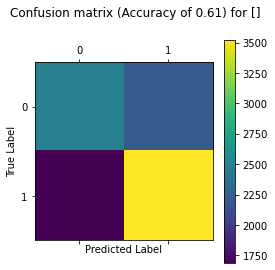

No handles with labels found to put in legend.


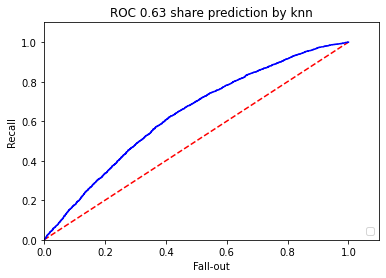

In [111]:
# matrice de confusion KNN

draw_confusion_matrix(y_test_knn, knn.predict(X_test_knn), "")
draw_roc_curve(knn, X_test_knn, y_test_knn, "share prediction by knn")

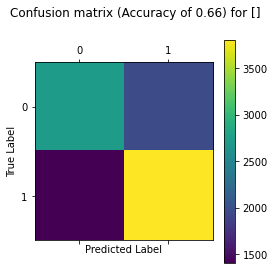

No handles with labels found to put in legend.


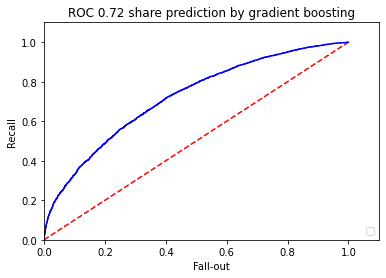

In [112]:
# matrice de confusion gradient boosting classifier

draw_confusion_matrix(y_test, gbc.predict(X_test), "")
draw_roc_curve(gbc, X_test, y_test, "share prediction by gradient boosting")

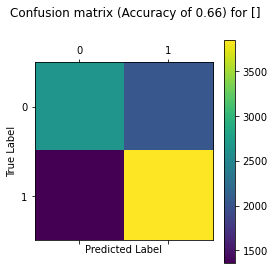

No handles with labels found to put in legend.


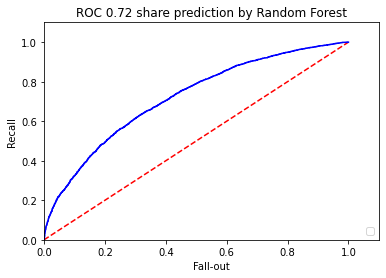

In [113]:
# matrice de confusion random forest
draw_confusion_matrix(y_test, rf.predict(X_test), "")
draw_roc_curve(rf, X_test, y_test, "share prediction by Random Forest")

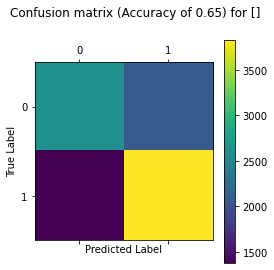

No handles with labels found to put in legend.


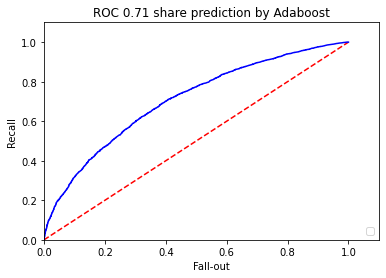

In [114]:
# matrice de confusion adaboost

draw_confusion_matrix(y_test, ada.predict(X_test), "")
draw_roc_curve(ada, X_test, y_test, "share prediction by Adaboost")


Nos meilleures prédictions sont faites avec le random forest classifier et le gradient boost classifier.
Elles ont une accuracy de seulement 66%. Cela est un peu en dessous des résultats obtenue par [K. Fernandes](https://www.researchgate.net/publication/283510525_A_Proactive_Intelligent_Decision_Support_System_for_Predicting_the_Popularity_of_Online_News) aillant travailler sur ce dataset.



On peut remarquer que la plupart des modèles peuvent être améliorés (jusqu'a 72% environs)

## 9. Save best model and test data to CSV

In [115]:
import pickle

In [116]:
# save the model to disk
filename = 'best_model.pkl'
## Sauvegarde du random forest classifier car il nous donne les meilleurs résultats.
pickle.dump(rf, open(filename, 'wb'))

In [117]:
# Sauvegarde des donnees de train sur lesquelles le dataset ne s'est pas entrainé
# Nous allons utilisé ce fichier dans l'api afin de faire des prédictions sur lesquelles on ne s'est pas entrainé
# De plus cela nous permet de garder la même structure de data pour l'api (ajout/suppression de colonne, normalisation des données ect...)
pd.DataFrame(X_test).to_csv('OnlineNewsPopularity/x_test.csv', sep=";")

In [118]:
pd.DataFrame(y_test).to_csv('OnlineNewsPopularity/y_test.csv', sep=";")